In [1]:
import matplotlib.pyplot as plt
from freegs.machine import Coil, Solenoid, Machine
from freegs.jtor import ConstrainBetapIp
from freegs.equilibrium import Equilibrium
from freegs.control import constrain
from freegs import solve
from SOUTH_param import * 

In [64]:
# Parameters subject to change 
PR1 = 0.15
PZ1 = 0.35
PR2 = 0.30
PZ2 = 0.275
PR3 = 0.45
PZ3 = 0.10

coils_positioning = [
    (PR1, PZ1),
    (PR2, PZ2),
    (PR3, PZ3)
]

Ip = 10e3  # Plasma current [Amps]
toroidal_magnetic_field_strength_at_plasma_centre = 0.125 # B_0

R1 = 75e-3
R2 = 550e-3

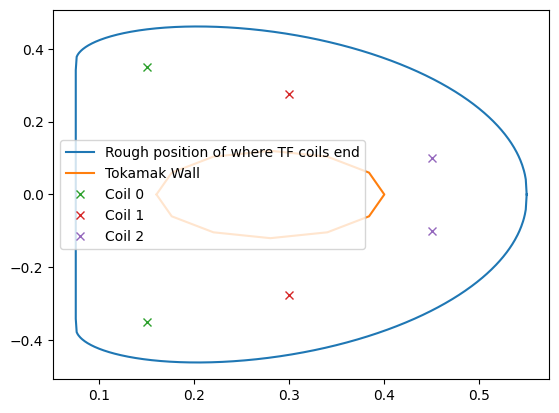

In [65]:
plt.plot(*PrincetonDee(R1, R2), label='Rough position of where TF coils end')
plt.plot(RWall, ZWall, label='Tokamak Wall')

for index, (r, z) in enumerate(coils_positioning):
    plt.plot([r, r], [z, -z], 'x', label='Coil {}'.format(index))
plt.legend()

In [52]:
# Create coils
central_solenoid = [("SOL", Solenoid((inner_radius + outer_radius) / 2, -solenoid_height / 2,  solenoid_height / 2, solenoid_turns, control=False))]

poloidal_coils = [
    ("VF1_U", Coil(PR1, PZ1)),
    ("VF1_L", Coil(PR1, -PZ1)),
    ("VF2_U", Coil(PR2, PZ2)),
    ("VF2_L", Coil(PR2, -PZ2)),
    ("SH1_U", Coil(PR3, PZ3)),
    ("SH1_L", Coil(PR3, -PZ3))
]

In [53]:
# Create tokamak
tokamak = Machine(
    central_solenoid + poloidal_coils,
    walls
)
tokamak['VF1_U'].area = tokamak['VF1_L'].area = tokamak['VF2_U'].area = tokamak['VF2_L'].area = tokamak['SH1_U'].area = tokamak['SH1_L'].area = 4 * 2.1e-4

In [54]:
# Define simulation granularity
eq = Equilibrium(tokamak=tokamak,
                       Rmin=0.01, Rmax=0.7,    # Radial domain
                       Zmin=-0.6, Zmax=0.6,    # Height range
                       nx=129, ny=129          # Number of grid points
                       )

In [55]:
# Define plasma properties constraints
vacuum_toroidal_magnetic_field = plasma_major_radius * toroidal_magnetic_field_strength_at_plasma_centre
profiles = ConstrainBetapIp(eq,
                            0.05,   # Plasma poloidal beta
                            Ip,     # Plasma current [Amps]
                            vacuum_toroidal_magnetic_field)  # Vacuum f=R*Bt

In [56]:
# Define x-points and iso-flux
xpoints = [(0.3, -0.24), (0.3, 0.24)]  # (R,Z) locations of X-points
isoflux = [(0.3, -0.24, 0.3, 0.24)] # (R1,Z1, R2,Z2) pairs

constraints = constrain(xpoints=xpoints, isoflux=isoflux)

In [57]:
solve(eq,
             profiles,
             constraints,
             check_limited=True,
             limit_it = 0
             )
print(
    tokamak.getForces(),
    tokamak.printCurrents()
)

SOL : Solenoid(Rs=0.055499999999999994, Zsmin=-0.47, Zsmax=0.47, current=0.0, Ns=104, control=False)
VF1_U : Coil(R=0.15, Z=0.35, current=20.2, turns=1, control=True)
VF1_L : Coil(R=0.15, Z=-0.35, current=19.1, turns=1, control=True)
VF2_U : Coil(R=0.3, Z=0.275, current=567.0, turns=1, control=True)
VF2_L : Coil(R=0.3, Z=-0.275, current=567.1, turns=1, control=True)
SH1_U : Coil(R=0.45, Z=0.1, current=-2587.6, turns=1, control=True)
SH1_L : Coil(R=0.45, Z=-0.1, current=-2588.2, turns=1, control=True)
Net Current is 6349.19
{'SOL': {}, 'VF1_U': array([-0.04198185,  0.01039899]), 'VF1_L': array([-0.03984575, -0.0098586 ]), 'VF2_U': array([-3.47447744,  2.45508847]), 'VF2_L': array([-3.47514781, -2.45548128]), 'SH1_U': array([ 27.28288876, -16.99263863]), 'SH1_L': array([27.29181741, 16.99249105])} None


In [61]:
print(
    # eq.q(),
    eq.plasmaCurrent(), 
    eq.intersectsWall(), 
    eq.elongation(),
    # eq.elongationUpper(),
    # eq.elongationLower(), 
    eq.triangularity(),
    # eq.triangularityUpper(),
    # eq.triangularityLower()
)

10000.0 False 1.1901306688459805 0.03636824462502647
